In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

sys.path.append("../input/modules")
from utils.utils import read_hdf5
from models.cnn import Cnn14_DecisionLevelAtt
%load_ext autoreload
%autoreload 2

In [2]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()

1    1065
2     110
3      24
4      12
5       5
Name: count, dtype: int64

In [3]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [7]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


In [8]:
tp_list = train_tp["recording_id"].unique() + ".flac"
train_tp_list = []
for path in train_path_list:
    if path in tp_list:
        train_tp_list.append(os.path.join("../input/rfcx-species-audio-detection/train", path))

In [9]:
def logmelfilterbank(
    audio,
    sampling_rate,
    fft_size=1024,
    hop_size=256,
    win_length=None,
    window="hann",
    num_mels=80,
    fmin=None,
    fmax=None,
    eps=1e-10,
):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(
        audio,
        n_fft=fft_size,
        hop_length=hop_size,
        win_length=win_length,
        window=window,
        pad_mode="reflect",
    )
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))


In [10]:
y, sr = librosa.load(path=train_tp_list[10], sr=32000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y)
plt.subplot(2, 2, 2)
plt.imshow(logmel.T, aspect="auto")

plt.colorbar()
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)
plt.subplot(2, 2, 3)
plt.plot(y)
plt.subplot(2, 2, 4)
plt.imshow(logmel.T, aspect="auto")
plt.colorbar()

# plt.savefig("spec.png")

In [ ]:
(logmel.mean(axis=0) > -3).sum()

In [ ]:
logmel.shape

In [ ]:
train_tp_list[10].split("/")[-1][:-5]

In [ ]:
train_tp.sort_values('f_max')

In [ ]:
train_tp

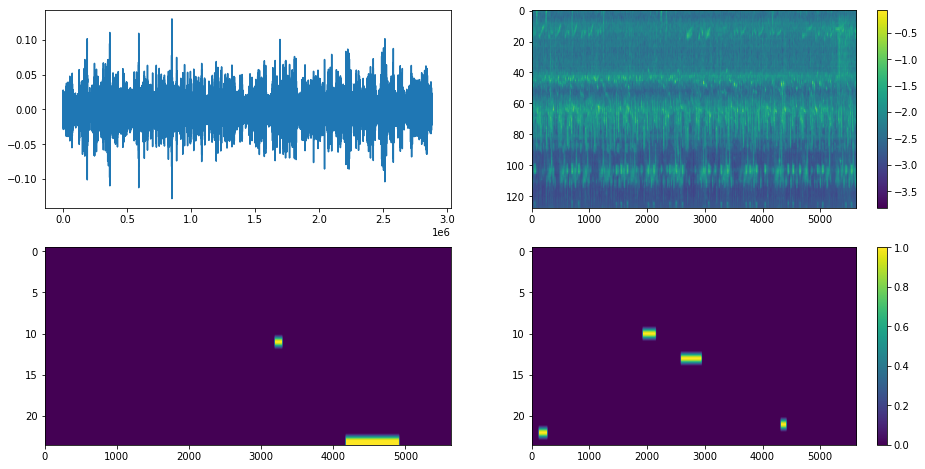

In [13]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(wave)
plt.subplot(2, 2, 2)
plt.imshow(mel.T, aspect="auto")
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(matrix_tp.T, aspect="auto")
plt.subplot(2, 2, 4)
plt.imshow(matrix_fp.T, aspect="auto")
plt.colorbar()

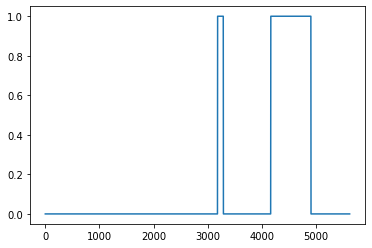

In [16]:
plt.plot(matrix_tp.sum(axis=1))

In [11]:
mel.shape

(5626, 128)

In [12]:
train_tp.sort_values("t_diff")

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count
960,c9fc89429,14,1,39.3493,3750.00,39.6213,6468.75,0.2720,2718.75,1
30,055088446,14,1,58.9920,3750.00,59.2640,6468.75,0.2720,2718.75,1
628,7ed4d3ca1,14,1,17.9520,3750.00,18.2240,6468.75,0.2720,2718.75,1
844,b1c09c89b,14,1,30.9493,3750.00,31.2213,6468.75,0.2720,2718.75,1
1124,e97de3f6d,14,1,56.6933,3750.00,56.9653,6468.75,0.2720,2718.75,1
...,...,...,...,...,...,...,...,...,...,...
402,551385b05,23,4,44.4372,6459.96,52.3610,11627.90,7.9238,5167.94,2
481,604583528,23,4,51.9314,6459.96,59.8552,11627.90,7.9238,5167.94,1
587,774912d66,23,4,29.7215,6459.96,37.6454,11627.90,7.9239,5167.94,2
107,16553d5cd,23,4,41.7088,6459.96,49.6327,11627.90,7.9239,5167.94,2


In [26]:
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=True,
        is_spec_augmenter=False,
        mixup_lambda=None,)
x = torch.tensor(wave[:288000]).unsqueeze(0)
y = model(x)

feature_map:torch.Size([1, 2048, 35, 2])
feature_map: mean-dim3torch.Size([1, 2048, 35])
pool1d_map: mean-dim3torch.Size([1, 2048, 35])


In [28]:
y["clipwise_output"].shape

torch.Size([1, 25])

In [39]:
train_tp[train_tp["count"] == 5]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,t_diff,f_diff,count
915,c12e0a62b,9,1,14.9653,1125.00,17.7707,5250.0,2.8054,4125.00,5
916,c12e0a62b,17,1,1.5467,1312.50,8.0000,3937.5,6.4533,2625.00,5
917,c12e0a62b,17,1,11.9200,1312.50,18.3733,3937.5,6.4533,2625.00,5
918,c12e0a62b,3,1,21.5680,1031.25,22.3093,2812.5,0.7413,1781.25,5
919,c12e0a62b,17,1,23.4880,1312.50,29.9413,3937.5,6.4533,2625.00,5


In [58]:
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [60]:
cnt = 0
for a in tp_list:
    if a in fp_list:
        cnt += 1
        print(cnt, a)

1 007f87ba2
2 015113cad
3 0209f7ab2
4 0275e127d
5 02b9a8ab9
6 0313e82cf
7 03b96f209
8 04e70a8e3
9 050d0ca85
10 053aeb7bd
11 068f1b8e2
12 06c44d203
13 073e4d908
14 078788674
15 08db743d0
16 090ae427d
17 09315d9bf
18 0968aea09
19 0a9cdd8a5
20 0b2fa3f80
21 0c48ed342
22 0e29d05ed
23 0eb2079ea
24 0f99800b7
25 100e4ddc9
26 119b154cc
27 11c2c02e5
28 1263c23c8
29 12ec1d4cb
30 13511f7bd
31 147b41b13
32 14f6cbe5c
33 1504619b7
34 158c5acb6
35 160add406
36 163e86660
37 16553d5cd
38 1679e323d
39 178b835e3
40 17ca96791
41 19442bf58
42 1a3993962
43 1a5fb3223
44 1aa00dc63
45 1aef4f8ff
46 1b77382c7
47 1ca8c8af6
48 1d949c49d
49 1e05620be
50 1e469c124
51 1ef3e2282
52 1fb94ae60
53 200656f13
54 20de9e491
55 2322ec1d3
56 23adb9473
57 275a0fc0c
58 27c146a88
59 288e5d13f
60 29127020a
61 2bb539997
62 2bcddf9a5
63 2bf32cf03
64 2c97a8020
65 2cd094d21
66 2ce34e1b6
67 2d09eb065
68 2e6758f3e
69 2eb098e76
70 2f40810b2
71 2f594b20f
72 2fc2eca0c
73 2febbdfc5
74 2ffaa6c02
75 32278292a
76 33d0f2685
77 340c7f964
78 34340